# start

In [1]:
PRFX = 'MelPrp0628B1'

In [2]:
MAXSZ = 512

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from PIL import Image

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


In [4]:
p_cmp = '../input/siim-isic-melanoma-classification'
p_19 = '../input/andrewmvd--isic-2019'
p_out = '../output/{PRFX}'
p_out = f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)

# eda

In [5]:
mkdir -p $p_out/siim-isic-melanoma-classification/jpeg/train

In [23]:
mkdir -p $p_out/siim-isic-melanoma-classification/jpeg/test

In [7]:
mkdir -p $p_out/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input

In [8]:
dftrain=pd.read_csv(f'{p_cmp}/train.csv')
dftrain['im_pth'] = f'{p_cmp}/jpeg/train/'+dftrain.image_name+'.jpg'
dftrain.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,im_pth
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,../input/siim-isic-melanoma-classification/jpe...


In [9]:
dftest=pd.read_csv(f'{p_cmp}/test.csv')
dftest['im_pth'] = f'{p_cmp}/jpeg/test/'+dftest.image_name+'.jpg'
dftest.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0073313,IP_6375035,female,50.0,torso,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,../input/siim-isic-melanoma-classification/jpe...


In [31]:
df19=pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
df19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+df19.image+'.jpg'
df19.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,im_pth
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/andrewmvd--isic-2019/ISIC_2019_Traini...


(5184, 3456)


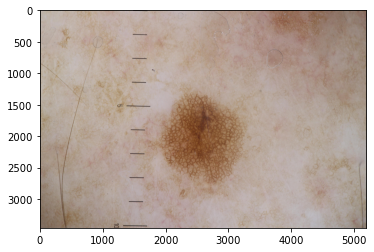

(6000, 4000)


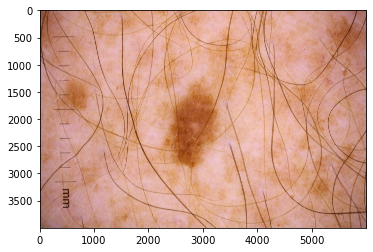

(600, 450)


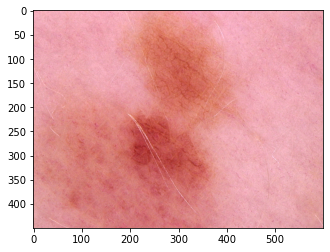

In [11]:
for df in [dftrain,dftest,df19]:
    fnm = np.random.choice(df.im_pth)
    im = Image.open(fnm)
    print(im.size)
    plt.imshow(im)
    plt.show()

(6000, 4000)

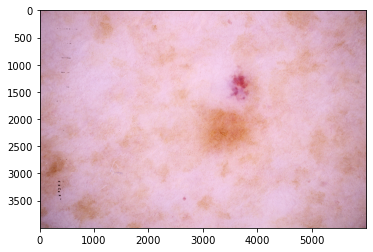

In [12]:
fnm = np.random.choice(dftrain.im_pth)
im = Image.open(fnm)
plt.imshow(im)
im.size

In [13]:
w,h=im.size
w,h

(6000, 4000)

In [14]:
def maybe_resize(im, maxsz=MAXSZ):
    w,h=im.size
    if max(w,h)<=maxsz: return im
    elif w>maxsz: 
        w_new = maxsz
        h_new = int(maxsz*h/w)
    else:
        h_new = maxsz
        w_new = int(maxsz*w/h)
    return im.resize((w_new,h_new))

(512, 341)

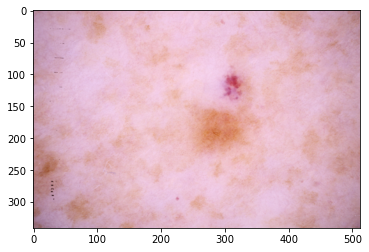

In [15]:
im_new = maybe_resize(im)
plt.imshow(im_new)
im_new.size

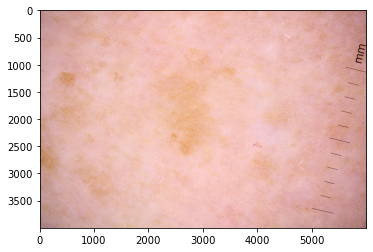

(6000, 4000)
(512, 341)


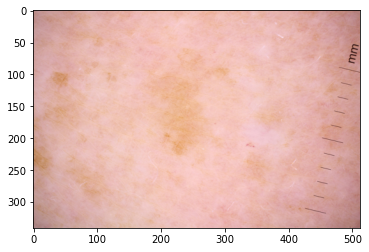

In [16]:
fnm = np.random.choice(dftrain.im_pth)
im = Image.open(fnm)
plt.imshow(im);
plt.show()
print(im.size)
im_new = maybe_resize(im)
plt.imshow(im_new)
print(im_new.size)

# run

In [17]:
def process(fnm):
    fnm_new = fnm.replace('../input', p_out)
    if os.path.exists(fnm_new): return
    im = Image.open(fnm)
    im_new = maybe_resize(im)
    im_new.save(fnm_new)

In [20]:
im_pths = np.concatenate([df.im_pth.values for df in (dftrain,dftest,df19)])
len(im_pths)

69439

In [26]:
Parallel(n_jobs=6, verbose=10)(delayed(process)(fnm) for fnm in im_pths)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0168s.) Setting batch_size=4.
[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0186s.) Setting batch_size=8.
[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0154s.) Setting batch_size=16.
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0138s.) Setting batch_size=32.
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Bat

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# inspect results

../input/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0011205.jpg


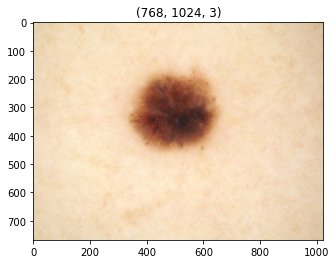

../output/MelPrp0628B1/andrewmvd--isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0011205.jpg


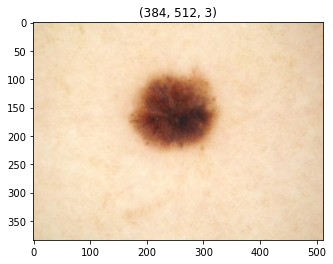

../input/siim-isic-melanoma-classification/jpeg/test/ISIC_7240170.jpg


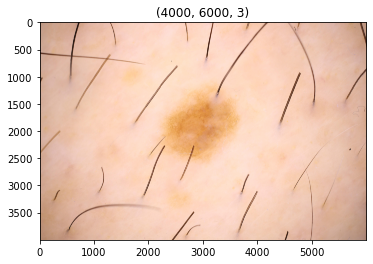

../output/MelPrp0628B1/siim-isic-melanoma-classification/jpeg/test/ISIC_7240170.jpg


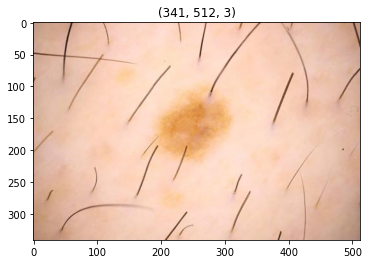

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_4425322.jpg


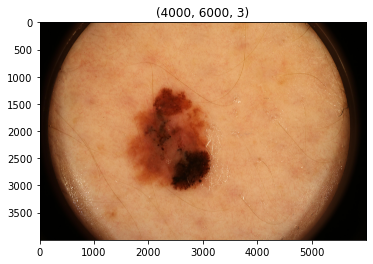

../output/MelPrp0628B1/siim-isic-melanoma-classification/jpeg/train/ISIC_4425322.jpg


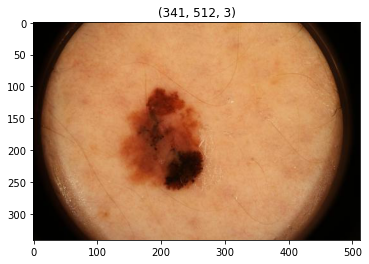

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_5532861.jpg


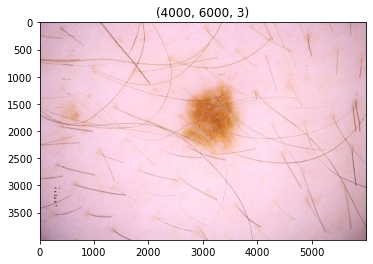

../output/MelPrp0628B1/siim-isic-melanoma-classification/jpeg/train/ISIC_5532861.jpg


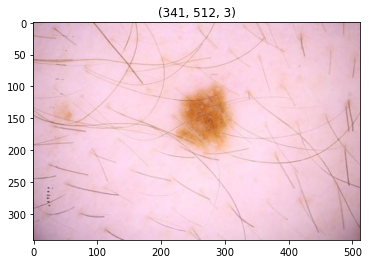

../input/siim-isic-melanoma-classification/jpeg/train/ISIC_3033977.jpg


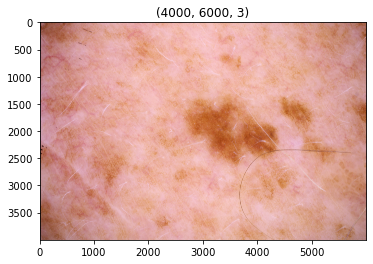

../output/MelPrp0628B1/siim-isic-melanoma-classification/jpeg/train/ISIC_3033977.jpg


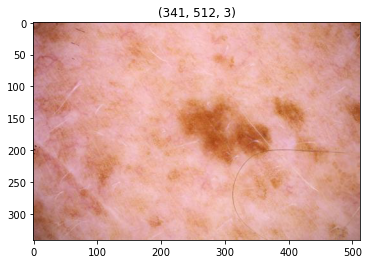

In [30]:
fnms = np.random.choice(im_pths, 5, replace=False)
for fnm in fnms:
    print(fnm)
    img = plt.imread(fnm)
    plt.title(f'{img.shape}')
    plt.imshow(img)
    plt.show()
    
    fnm_new = fnm.replace('../input', p_out)
    print(fnm_new)
    img = plt.imread(fnm_new)
    plt.title(f'{img.shape}')
    plt.imshow(img)
    plt.show()
    

# make csv

In [36]:
train,test,sample_submission = (pd.read_csv(o) for o in [f'{p_cmp}/{o}.csv' 
                                                         for o in ('train', 'test', 'sample_submission')])
print([o.shape for o in (train,test,sample_submission)])

train19 = pd.read_csv(f'{p_19}/ISIC_2019_Training_GroundTruth.csv')
train19meta = pd.read_csv(f'{p_19}/ISIC_2019_Training_Metadata.csv')

assert np.all(train19.image==train19meta.image)
train19['patient_id']=train19meta['lesion_id']

train['source'] = '20'
train['im_pth'] = f'{p_cmp}/jpeg/train/'+train.image_name+'.jpg'
train19['source'] = '19'
train19['target'] = train19.MEL
train19['im_pth'] = f'{p_19}/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+train19.image+'.jpg'

cols2use=['source', 'im_pth', 'patient_id', 'target', ]
train_all = pd.concat([train[cols2use], train19[cols2use]])
display(train_all.shape)
display(train_all.source.value_counts())
display(train_all.groupby('source').target.mean())

test['im_pth']=f'{p_cmp}/jpeg/test/'+test.image_name+'.jpg'

[(33126, 8), (10982, 5), (10982, 2)]


(58457, 4)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

In [37]:
train_all.im_pth = train_all.im_pth.apply(lambda x: x.replace('../input', p_out))

In [38]:
test.im_pth = test.im_pth.apply(lambda x: x.replace('../input', p_out))

In [40]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0628B1/siim-isic-melanoma-clas...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0628B1/siim-isic-melanoma-clas...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0628B1/siim-isic-melanoma-clas...
3,ISIC_0073313,IP_6375035,female,50.0,torso,../output/MelPrp0628B1/siim-isic-melanoma-clas...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,../output/MelPrp0628B1/siim-isic-melanoma-clas...


In [39]:
train_all.to_csv(f'{p_out}/train_all.csv', index=False)
test.to_csv(f'{p_out}/test.csv', index=False)